In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import csv
from torch.optim import SGD
from skimage import io as skio
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
from skimage import io
import cv2 as cv
import os
import torchvision.models as models
import base64
import json
import skimage.io as skio
import io
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.preprocessing import label_binarize
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from tabulate import tabulate


In [2]:
checkpoint_path = "/Users/abhisheksharma/Downloads/local_model (copy)/weights/bce_masked_adam8.pth.tar"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
def create_densenet121(num_classes):
    # Load the DenseNet121 model without pre-trained weights
    model = models.densenet121(weights=None)
    
    # Modify the last fully connected layer to have the output features equal to the number of classes
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, num_classes)
    
    return model

def generate_gradcam(model, input_tensor, original_image, target_category=None):
    
    target_layers = model.features.denseblock4.denselayer16.conv2

    #target_layers = model.features[-1]

    # Initialize Grad-CAM with the specified target layers
    cam = GradCAM(model=model, target_layers=[target_layers])  # Encapsulate target_layers in a list
    
    # Define targets based on the specified target category
    targets = [ClassifierOutputTarget(target_category)] if target_category is not None else None
    
    # Generate CAM mask
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

    # Create visualization with the specified alpha for the overlay transparency
    visualization = show_cam_on_image(np.array(original_image) / 255.0, grayscale_cam, use_rgb=True, alpha=0.3) # Adjust alpha as needed

    return visualization

In [5]:
# Function to load checkpoint
def local_load_checkpoint(model, optimizer,device):
    checkpoint = torch.load(checkpoint_path,map_location=torch.device(device))
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.eval()  # Set the model to evaluation mode
    print(f"Checkpoint loaded from '{checkpoint_path}'")
    return model, optimizer

In [6]:
def show_cam_on_image(img, mask, use_rgb=True, alpha=0.5):
    # Convert mask to a heatmap
    heatmap = cv.applyColorMap(np.uint8(255 * mask), cv.COLORMAP_JET)
    if use_rgb:
        heatmap = cv.cvtColor(heatmap, cv.COLOR_BGR2RGB)
        img = cv.cvtColor(np.uint8(255 * img), cv.COLOR_BGR2RGB)
    else:
        img = np.uint8(255 * img)
    # Blend the heatmap with the original image
    overlayed_img = cv.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return overlayed_img


In [7]:
def test_single_image(filepath, csv_file_path, thresholds, model, device):
    # Read and preprocess the image
    image = cv.imread(filepath)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    original_image = Image.fromarray(image)
    original_image = original_image.resize((256, 256))

    # Convert the image to a PyTorch tensor and enable gradient
    to_tensor = transforms.ToTensor()
    image_tensor = to_tensor(original_image).unsqueeze(0).requires_grad_(True)
    image_tensor = image_tensor.to(device)

    # Ensure the model is on the correct device and set it to training mode temporarily
    model = model.to(device)
    model.train()  # Enable tracking of gradients

    prediction = []
    true_labels = []
    grad_cam_image = []

    # Perform forward pass to get predictions and the last convolutional layer's activations
    with torch.enable_grad():  # Ensure gradients are computed
        outputs = model(image_tensor)
        probability = torch.sigmoid(outputs).detach().cpu().numpy()

        # Generate Grad-CAM for the highest scoring category
        _, target_category = torch.max(outputs, 1)

        for x in range (0,6):
            grad_cam_image.append(generate_gradcam(model,image_tensor, original_image, target_category=x))
            
    # Optionally, switch back to evaluation mode
    model.eval()
    
    # Extract true labels from CSV file
    filename_without_extension = os.path.splitext(os.path.basename(filepath))[0]
    with open(csv_file_path, 'r') as f:
        datareader = csv.reader(f)
        for row in datareader:
            if row[0] == filename_without_extension:
                true_labels.extend([int(float(row[i])) if row[i] == '1.0' else 0 for i in [12, 13, 14, 15, 20, 21]])
                break

    # Compare predictions and true labels
    for i in range(6):
        prediction.append(1 if probability[0][i] >= thresholds[i] else 0)

    print("probability: ", probability)
    print("prediction: ", prediction)
    print("true lables: ", true_labels)

    # Create a table for visualization
    array1 = ['Atelectasis', probability[0][0], prediction[0], true_labels[0]]
    array2 = ['Cardiomegaly', probability[0][1], prediction[1], true_labels[1]]
    array3 = ['Consolidation', probability[0][2], prediction[2], true_labels[2]]
    array4 = ['Edema', probability[0][3], prediction[3], true_labels[3]]
    array5 = ['No Finding', probability[0][4], prediction[4], true_labels[4]]
    array6 = ['Pleural Effusion', probability[0][5], prediction[5], true_labels[5]]

    table = [['Disease', 'Model Probability', 'Model Prediction', 'True Labels'],
             array1, array2, array3, array4, array5, array6]

    # Print the table
    print("\n")
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

    return original_image, grad_cam_image, prediction


In [8]:
def test_single_image_no_csv(filepath, thresholds, model, device):
    # Read and preprocess the image
    image = cv.imread(filepath)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    original_image = Image.fromarray(image)
    original_image = original_image.resize((256, 256))

    # Convert the image to a PyTorch tensor and enable gradient
    to_tensor = transforms.ToTensor()
    image_tensor = to_tensor(original_image).unsqueeze(0).requires_grad_(True)
    image_tensor = image_tensor.to(device)

    # Ensure the model is on the correct device and set it to training mode temporarily
    model = model.to(device)
    model.train()  # Enable tracking of gradients

    prediction = []
    true_labels = []
    grad_cam_image = []

    # Perform forward pass to get predictions and the last convolutional layer's activations
    with torch.enable_grad():  # Ensure gradients are computed
        outputs = model(image_tensor)
        probability = torch.sigmoid(outputs).detach().cpu().numpy()

        # Generate Grad-CAM for the highest scoring category
        _, target_category = torch.max(outputs, 1)

        for x in range (0,6):
            grad_cam_image.append(generate_gradcam(model,image_tensor, original_image, target_category=x))
            
    # Optionally, switch back to evaluation mode
    model.eval()
    

    # Compare predictions and true labels
    for i in range(6):
        prediction.append(1 if probability[0][i] >= thresholds[i] else 0)

    print("probability: ", probability)
    print("prediction: ", prediction)

    # Create a table for visualization
    array1 = ['Atelectasis', probability[0][0], prediction[0] ]
    array2 = ['Cardiomegaly', probability[0][1], prediction[1]]
    array3 = ['Consolidation', probability[0][2], prediction[2]]
    array4 = ['Edema', probability[0][3], prediction[3]]
    array5 = ['No Finding', probability[0][4], prediction[4]]
    array6 = ['Pleural Effusion', probability[0][5], prediction[5]]

    table = [['Disease', 'Model Probability', 'Model Prediction'],
             array1, array2, array3, array4, array5, array6]

    # Print the table
    print("\n")
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

    return original_image, grad_cam_image, prediction


In [9]:
def plot_images(original_image, grad_cam_image, diseaseName):
    # Create a figure with 2 subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the original image
    axs[0].imshow(original_image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')  # Hide the axes ticks

    # Plot the Grad-CAM heatmap
    axs[1].imshow(grad_cam_image)
    axs[1].set_title('Grad-CAM Heatmap for ' + diseaseName)
    axs[1].axis('off')  # Hide the axes ticks

    # Display the plot
    plt.show()

In [10]:
def jpg256(jpg_path):
        image = skio.imread(jpg_path)
        RGB = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        new_image = Image.fromarray(RGB)
        new_image = new_image.resize((256, 256))
        return new_image


def Tensor256(jpg_path):
        image = skio.imread(jpg_path)
        RGB = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        new_image = Image.fromarray(RGB)
        new_image = new_image.resize((256, 256))

        to_tensor = transforms.ToTensor()
        image_tensor = to_tensor(new_image)
        #new_image =  to_tensor(new_image).unsqueeze(0).requires_grad_(True)
        #image_tensor = image_tensor.to(device)
        return image_tensor


#Grad_Tensor256 is not tested
def Grad_Tensor256(jpg_path,device):
        image = skio.imread(jpg_path)
        RGB = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        new_image = Image.fromarray(RGB)
        new_image = new_image.resize((256, 256))

        to_tensor = transforms.ToTensor()
        new_image =  to_tensor(new_image).unsqueeze(0).requires_grad_(True)
        image_tensor = image_tensor.to(device)
        return to_tensor


def image_to_base64(image_array):
    image = Image.fromarray(np.uint8(image_array)).convert('RGB')
    img_byte_arr = io.BytesIO()
    image.save(img_byte_arr, format='JPEG')
    return base64.b64encode(img_byte_arr.getvalue()).decode('utf-8')


# Function to preprocess and convert image to byte array
def preprocess_and_convert_to_byte_array(image_path):
    # Preprocess the image
    image = skio.imread(image_path)
    RGB = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    new_image = Image.fromarray(RGB)
    new_image = new_image.resize((256, 256))
    
    # Convert to byte array
    img_byte_arr = io.BytesIO()
    new_image.save(img_byte_arr, format='JPEG')
    img_byte_arr = img_byte_arr.getvalue()
    return img_byte_arr

# Function to convert byte array back to image
def byte_array_to_image(byte_array):
    img_byte_arr = io.BytesIO(byte_array)
    img = Image.open(img_byte_arr)
    return img


Checkpoint loaded from '/Users/abhisheksharma/Downloads/local_model (copy)/weights/bce_masked_adam8.pth.tar'
thresholds:  [0.53880334, 0.48418066, 0.36754248, 0.5815063, 0.54026645, 0.47844747]
probability:  [[0.43966445 0.5514946  0.46356338 0.3897353  0.52647656 0.5851617 ]]
prediction:  [0, 1, 1, 0, 0, 1]
true lables:  [0, 1, 0, 0, 0, 0]


╒══════════════════╤═════════════════════╤════════════════════╤═══════════════╕
│ Disease          │   Model Probability │   Model Prediction │   True Labels │
╞══════════════════╪═════════════════════╪════════════════════╪═══════════════╡
│ Atelectasis      │            0.439664 │                  0 │             0 │
├──────────────────┼─────────────────────┼────────────────────┼───────────────┤
│ Cardiomegaly     │            0.551495 │                  1 │             1 │
├──────────────────┼─────────────────────┼────────────────────┼───────────────┤
│ Consolidation    │            0.463563 │                  1 │             0 │
├──────────────

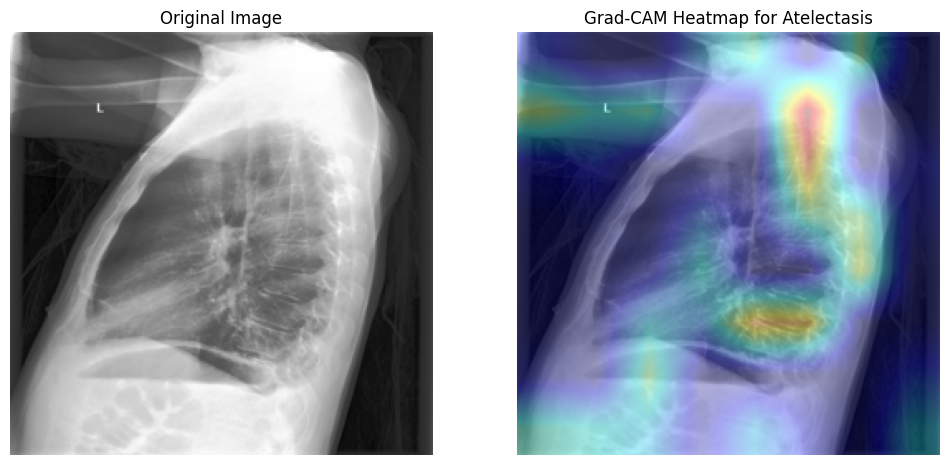

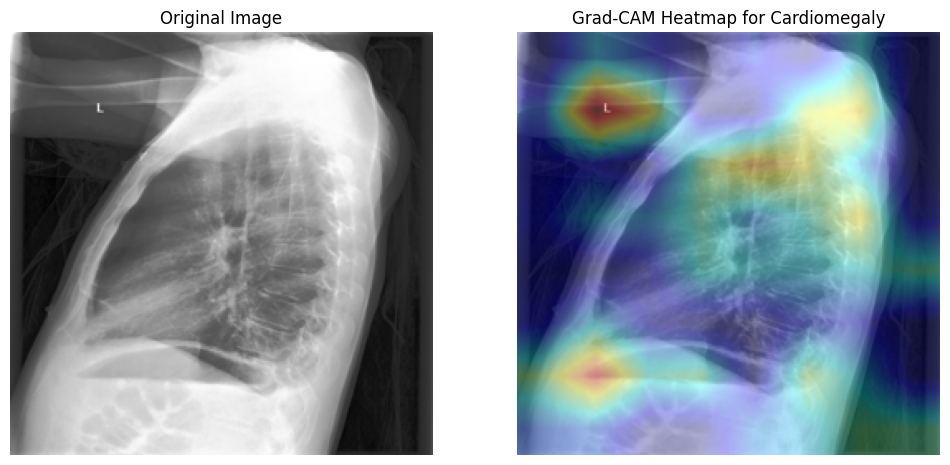

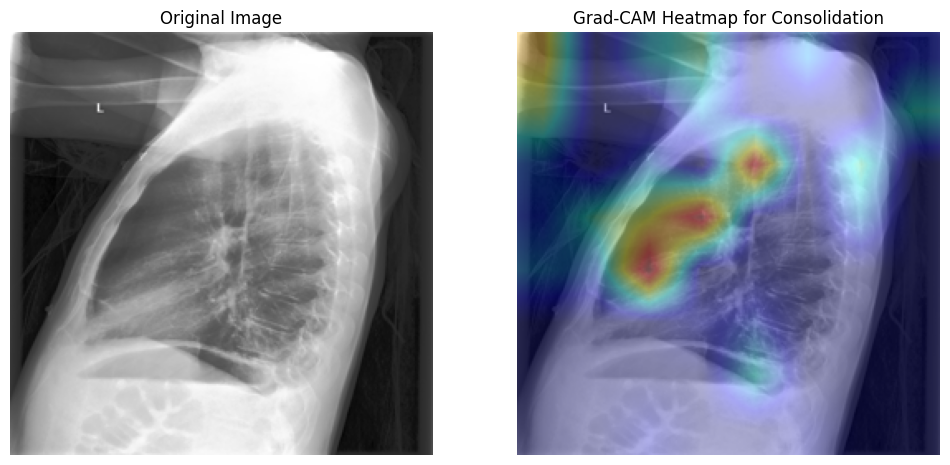

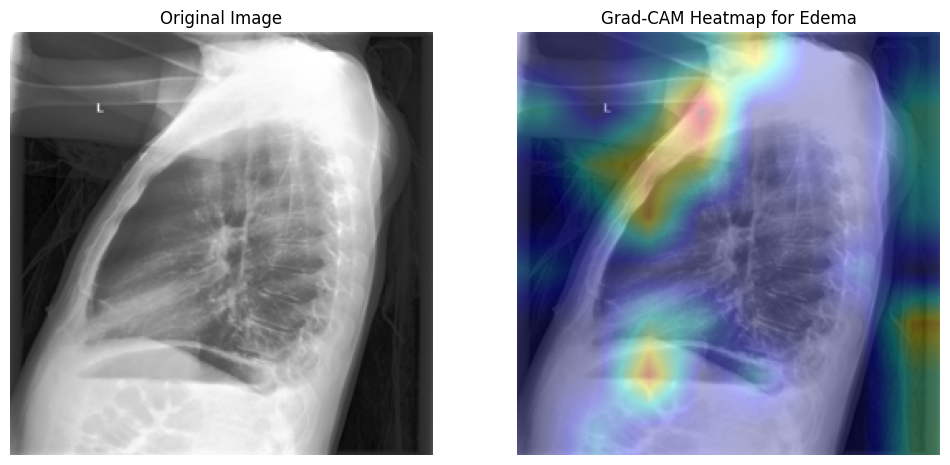

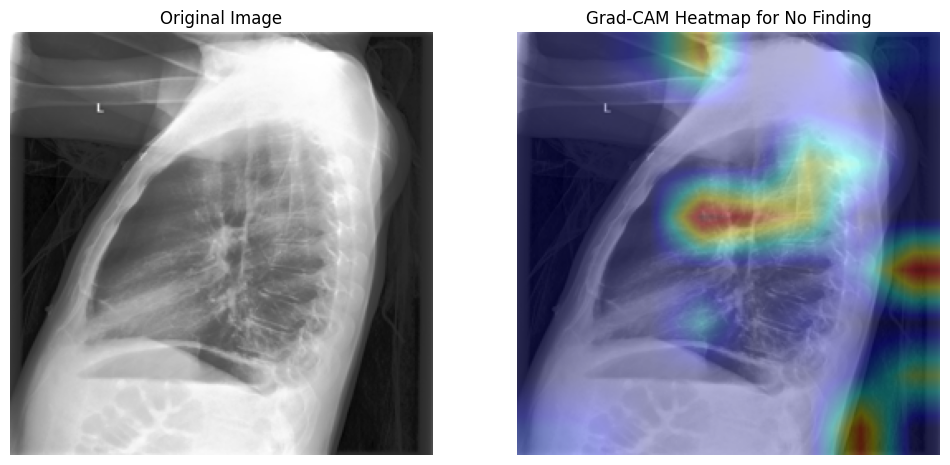

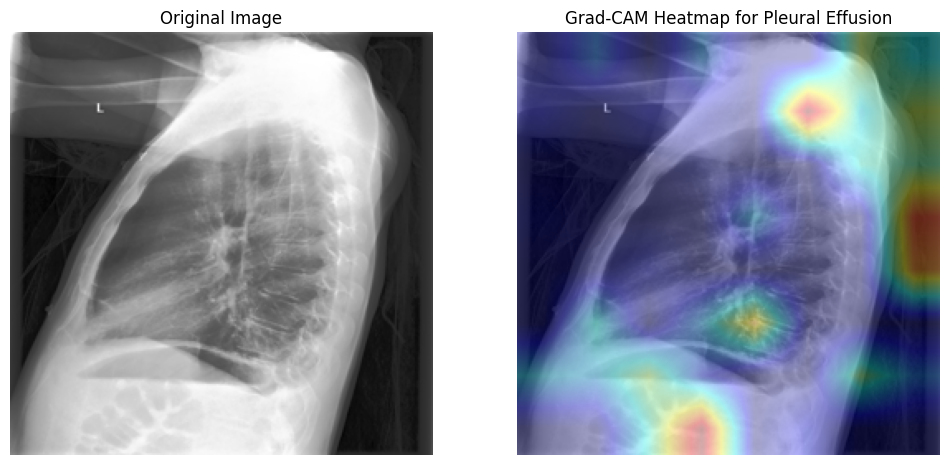

'{\n    "diseasesData": [\n        {\n            "diseaseName": "Atelectasis",\n            "prediction": 0,\n            "gradCamImage": "/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEAAQADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwC/4onkzKA5wBgD0rzG7J83JJr0XxDJ

In [12]:
# Test Single Image:

def run_with_csv(filepath, csv_file_path):

    #model = MyNeuralNet()
    model = create_densenet121(6)
    optimizer = torch.optim.Adam(model.parameters(), 0.001)
    loaded_model, loaded_optimizer = local_load_checkpoint(model, optimizer,device)
    loaded_model.eval()
    loaded_model.to(device)

    #filepath = "/Users/abhisheksharma/Downloads/local_model (copy)/images/8c421366-9dbe0c06-c9eb74e9-ba9a1e34-f39d6739.jpg"
    #csv_file_path = "/Users/abhisheksharma/Downloads/local_model (copy)/Validation_Partial.csv"

    #thresholds are old and determine if model predictions are 1 or 0 based on model probability
    thresholds = [0.53880334, 0.48418066, 0.36754248, 0.5815063, 0.54026645, 0.47844747]
    diseaseNames = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "No Finding", "Pleural Effusion"]

    print("thresholds: ", thresholds)


    #is you use test_single_image or test_single_image_no_csv depends on if you have the true labels
    original_image, grad_cam_image, predictions = test_single_image(filepath, csv_file_path, thresholds, model, device)

    #original_image, grad_cam_image = test_single_image_no_csv(filepath, thresholds, model, device)

    for x in range(0,6):
        plot_images(original_image, grad_cam_image[x], diseaseNames[x])


    grad_cam_images_base64 = [image_to_base64(img) for img in grad_cam_image]

    diseases_data = []
    for i, disease_name in enumerate(diseaseNames):
        diseases_data.append({
            "diseaseName": disease_name,
            "prediction": predictions[i],
            "gradCamImage": grad_cam_images_base64[i]
        })

    data = { "diseasesData": diseases_data }

    # Convert the structured data to a JSON string
    json_data = json.dumps(data, indent=4)

    return json_data

run_with_csv("/Users/abhisheksharma/Downloads/local_model (copy)/images/8c421366-9dbe0c06-c9eb74e9-ba9a1e34-f39d6739.jpg", "/Users/abhisheksharma/Downloads/local_model (copy)/Validation_Partial.csv" )

Checkpoint loaded from '/Users/abhisheksharma/Downloads/local_model (copy)/weights/bce_masked_adam8.pth.tar'
thresholds:  [0.53880334, 0.48418066, 0.36754248, 0.5815063, 0.54026645, 0.47844747]
probability:  [[0.43966445 0.5514946  0.46356338 0.3897353  0.52647656 0.5851617 ]]
prediction:  [0, 1, 1, 0, 0, 1]


╒══════════════════╤═════════════════════╤════════════════════╕
│ Disease          │   Model Probability │   Model Prediction │
╞══════════════════╪═════════════════════╪════════════════════╡
│ Atelectasis      │            0.439664 │                  0 │
├──────────────────┼─────────────────────┼────────────────────┤
│ Cardiomegaly     │            0.551495 │                  1 │
├──────────────────┼─────────────────────┼────────────────────┤
│ Consolidation    │            0.463563 │                  1 │
├──────────────────┼─────────────────────┼────────────────────┤
│ Edema            │            0.389735 │                  0 │
├──────────────────┼─────────────────────┼──────

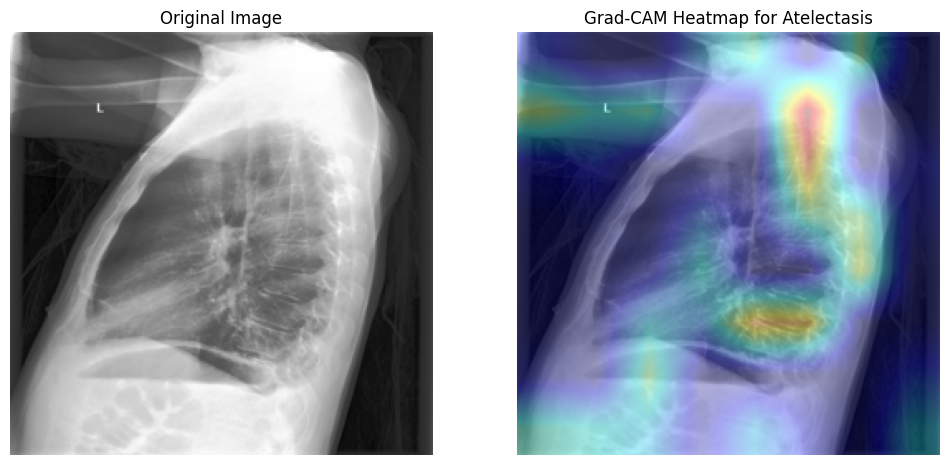

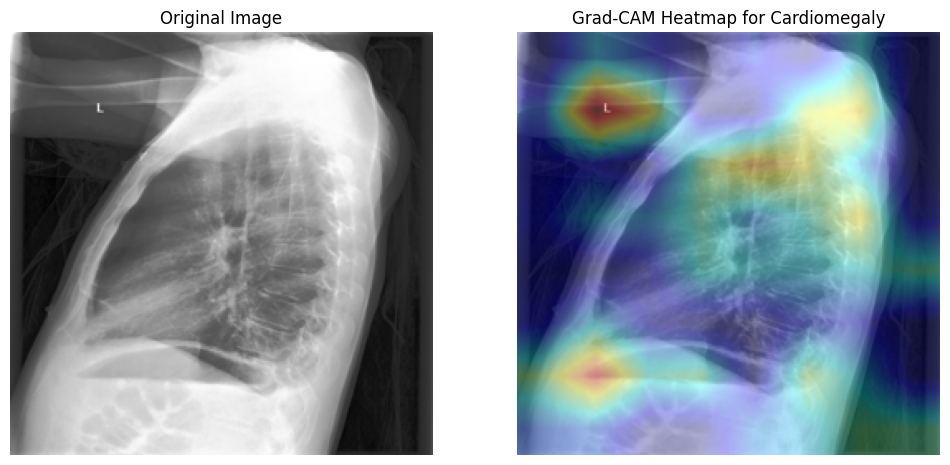

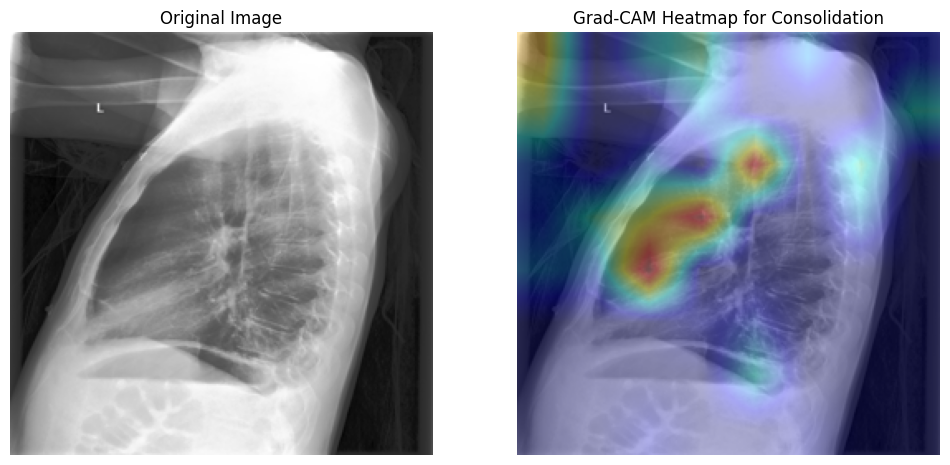

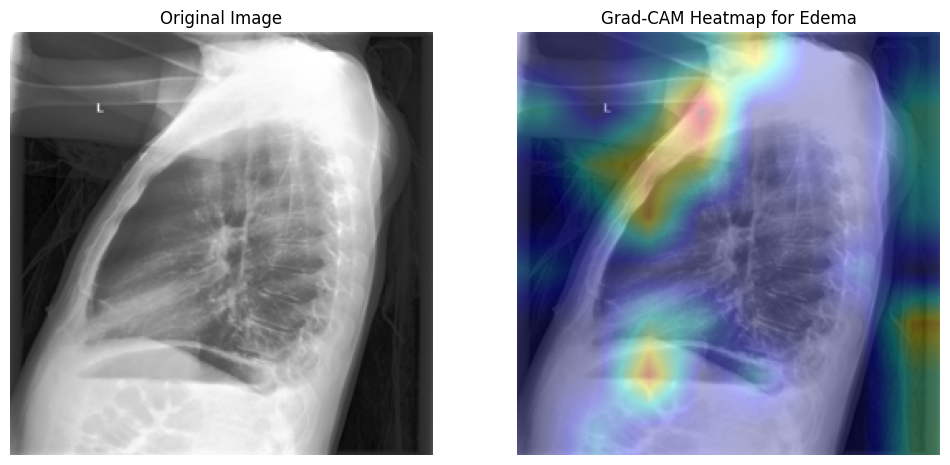

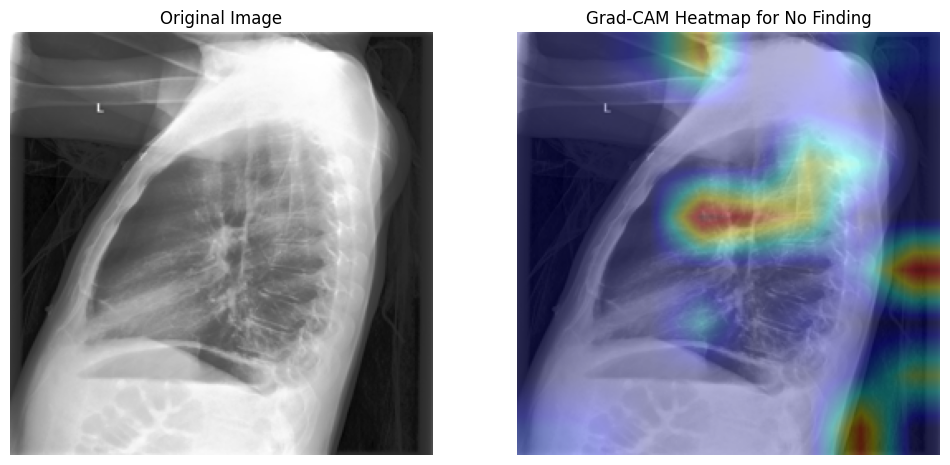

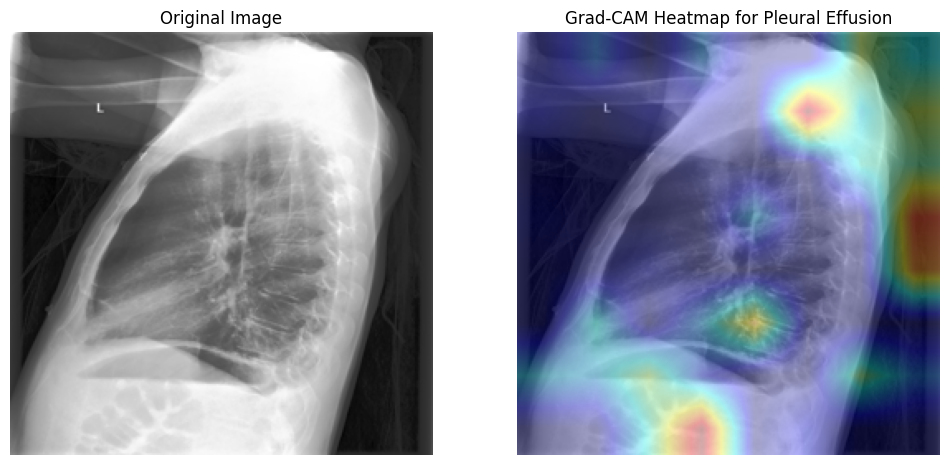

'{\n    "diseasesData": [\n        {\n            "diseaseName": "Atelectasis",\n            "prediction": 0,\n            "gradCamImage": "/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEAAQADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwC/4onkzKA5wBgD0rzG7J83JJr0XxDJ

In [13]:
# Test Single Image:

def run_with_no_csv(filepath):

    #model = MyNeuralNet()
    model = create_densenet121(6)
    optimizer = torch.optim.Adam(model.parameters(), 0.001)
    loaded_model, loaded_optimizer = local_load_checkpoint(model, optimizer,device)
    loaded_model.eval()
    loaded_model.to(device)

    #filepath = "/Users/abhisheksharma/Downloads/local_model (copy)/images/8c421366-9dbe0c06-c9eb74e9-ba9a1e34-f39d6739.jpg"
    #csv_file_path = "/Users/abhisheksharma/Downloads/local_model (copy)/Validation_Partial.csv"

    #thresholds are old and determine if model predictions are 1 or 0 based on model probability
    thresholds = [0.53880334, 0.48418066, 0.36754248, 0.5815063, 0.54026645, 0.47844747]
    diseaseNames = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "No Finding", "Pleural Effusion"]

    print("thresholds: ", thresholds)


    #is you use test_single_image or test_single_image_no_csv depends on if you have the true labels
    original_image, grad_cam_image, predictions = test_single_image_no_csv(filepath, thresholds, model, device)

    #original_image, grad_cam_image = test_single_image_no_csv(filepath, thresholds, model, device)

    for x in range(0,6):
        plot_images(original_image, grad_cam_image[x], diseaseNames[x])


    grad_cam_images_base64 = [image_to_base64(img) for img in grad_cam_image]

    diseases_data = []
    for i, disease_name in enumerate(diseaseNames):
        diseases_data.append({
            "diseaseName": disease_name,
            "prediction": predictions[i],
            "gradCamImage": grad_cam_images_base64[i]
        })

    data = { "diseasesData": diseases_data }

    # Convert the structured data to a JSON string
    json_data = json.dumps(data, indent=4)

    return json_data

run_with_no_csv("/Users/abhisheksharma/Downloads/local_model (copy)/images/8c421366-9dbe0c06-c9eb74e9-ba9a1e34-f39d6739.jpg")

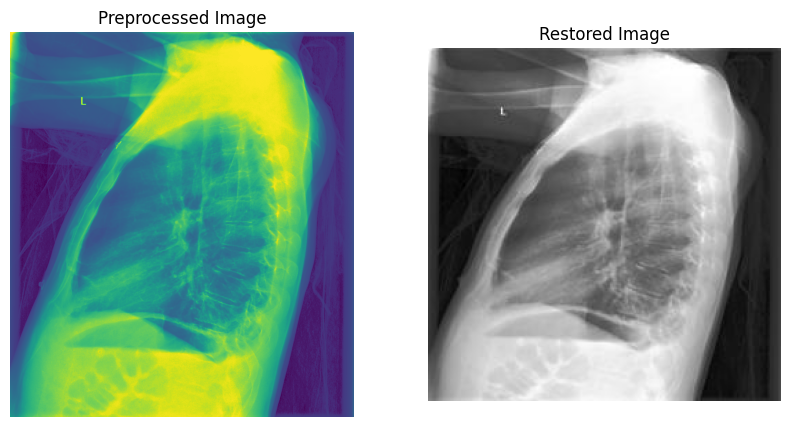

In [70]:
image_path = "/Users/abhisheksharma/Downloads/local_model (copy)/images/8c421366-9dbe0c06-c9eb74e9-ba9a1e34-f39d6739.jpg"

# Example usage
byte_array = preprocess_and_convert_to_byte_array(image_path)

# Convert byte array back to image
restored_image = byte_array_to_image(byte_array)

# Plotting preprocessed and restored images side by side
preprocessed_image = Image.open(image_path)  # Re-open the original image for comparison

# Create a figure to display the images
plt.figure(figsize=(10, 5))

# Plot preprocessed image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(preprocessed_image)
plt.title('Preprocessed Image')
plt.axis('off')  # Hide axis

# Plot restored image
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(restored_image)
plt.title('Restored Image')
plt.axis('off')  # Hide axis

plt.show()
